
Best alpha (λ) for Ridge: 2.9471

Ridge R²: 0.668
Ridge RMSE: 4.935

Best alpha (λ) for LASSO: 0.0010

Variables eliminated by LASSO: []

LASSO Coefficients:
crim      -0.999359
zn         0.691300
indus      0.268936
chas       0.718880
nox       -2.016029
rm         3.145868
age       -0.173778
dis       -3.074913
rad        2.233347
tax       -1.748999
ptratio   -2.035900
b          1.128372
lstat     -3.611403
dtype: float64

LASSO R²: 0.669
LASSO RMSE: 4.929


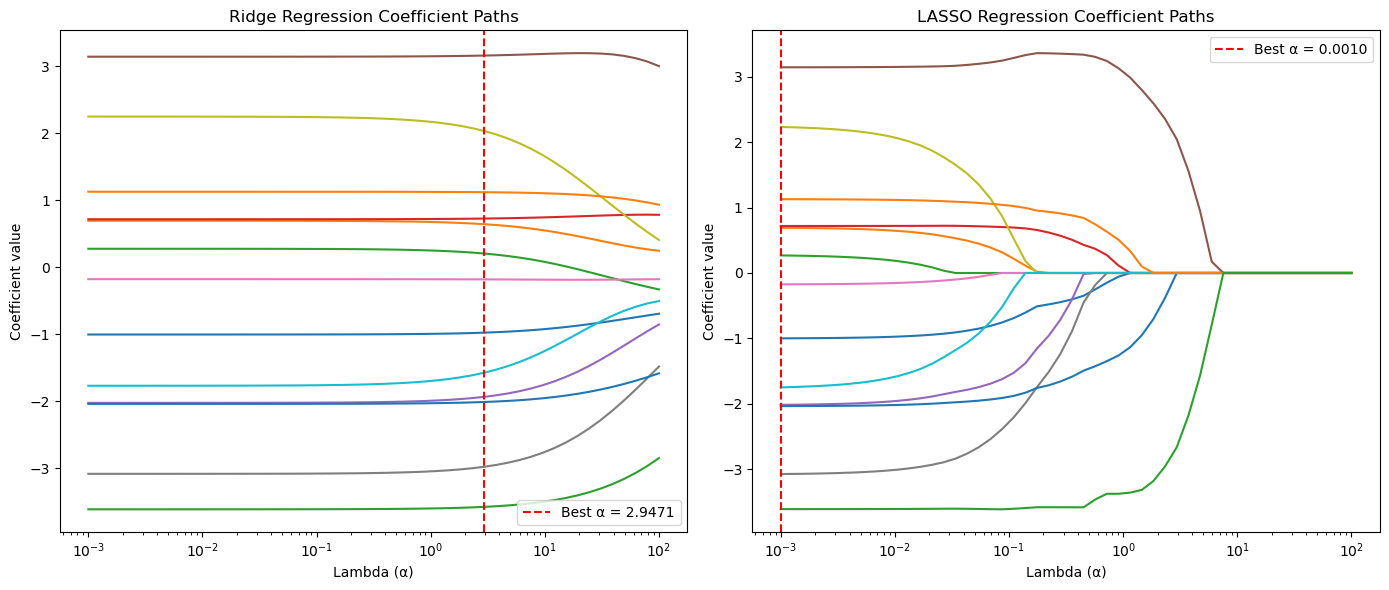


 MODEL COMPARISON
   Model  Best Alpha (λ)  R² Score      RMSE
0  LASSO        0.001000  0.668713  4.928949
1  Ridge        2.947052  0.667887  4.935086

LASSO Regression performs better.


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

url = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
boston = pd.read_csv(url)

boston.head()
# Handle missing values (simple mean imputation for numerical data and mode for categorical data)
#Chech for presence of missing value
boston.isna().sum()

### Separating features and target variables ###
X = boston.drop("medv", axis=1)  # medv = Median value of owner-occupied homes
y = boston["medv"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

################# RIDGE REGRESSION #################
ridge = Ridge()
params = {'alpha': np.logspace(-3, 2, 50)}

ridge_cv = GridSearchCV(ridge, params, cv=5)
ridge_cv.fit(X_train, y_train)

best_alpha_ridge = ridge_cv.best_params_['alpha']
print(f"\nBest alpha (λ) for Ridge: {best_alpha_ridge:.4f}")

#### Fitting final Ridge model
ridge_best = Ridge(alpha=best_alpha_ridge)
ridge_best.fit(X_train, y_train)

### Evaluate Ridge
y_pred_ridge = ridge_best.predict(X_test)
ridge_r2 = r2_score(y_test, y_pred_ridge)
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

print(f"\nRidge R²: {ridge_r2:.3f}")
print(f"Ridge RMSE: {ridge_rmse:.3f}")

############ LASSO REGRESSION  ###################

lasso = Lasso(max_iter=10000)
params = {'alpha': np.logspace(-3, 2, 50)}  # λ from 0.001 → 100

lasso_cv = GridSearchCV(lasso, params, cv=5)
lasso_cv.fit(X_train, y_train)

best_alpha_lasso = lasso_cv.best_params_['alpha']
print(f"\nBest alpha (λ) for LASSO: {best_alpha_lasso:.4f}")

#### Fitting final LASSO model ####
lasso_best = Lasso(alpha=best_alpha_lasso, max_iter=10000)
lasso_best.fit(X_train, y_train)

### Identifing eliminated (zero) variables
lasso_coeff = pd.Series(lasso_best.coef_, index=X.columns)
eliminated_vars = lasso_coeff[lasso_coeff == 0].index.tolist()

print("\nVariables eliminated by LASSO:", eliminated_vars)
print("\nLASSO Coefficients:")
print(lasso_coeff)

#### Evaluate LASSO
y_pred_lasso = lasso_best.predict(X_test)
lasso_r2 = r2_score(y_test, y_pred_lasso)
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

print(f"\nLASSO R²: {lasso_r2:.3f}")
print(f"LASSO RMSE: {lasso_rmse:.3f}")



#### Visualization

alphas = np.logspace(-3, 2, 50)
ridge_coefs = []
lasso_coefs = []

for a in alphas:
    ridge_temp = Ridge(alpha=a)
    ridge_temp.fit(X_train, y_train)
    ridge_coefs.append(ridge_temp.coef_)

    lasso_temp = Lasso(alpha=a, max_iter=10000)
    lasso_temp.fit(X_train, y_train)
    lasso_coefs.append(lasso_temp.coef_)

ridge_coefs = np.array(ridge_coefs)
lasso_coefs = np.array(lasso_coefs)

plt.figure(figsize=(14, 6))

# --- Ridge Plot ---
plt.subplot(1, 2, 1)
plt.plot(alphas, ridge_coefs)
plt.xscale('log')
plt.xlabel('Lambda (α)')
plt.ylabel('Coefficient value')
plt.title('Ridge Regression Coefficient Paths')
plt.axvline(best_alpha_ridge, color='red', linestyle='--', label=f'Best α = {best_alpha_ridge:.4f}')
plt.legend()

# --- LASSO Plot ---
plt.subplot(1, 2, 2)
plt.plot(alphas, lasso_coefs)
plt.xscale('log')
plt.xlabel('Lambda (α)')
plt.ylabel('Coefficient value')
plt.title('LASSO Regression Coefficient Paths')
plt.axvline(best_alpha_lasso, color='red', linestyle='--', label=f'Best α = {best_alpha_lasso:.4f}')
plt.legend()

plt.tight_layout()
plt.show()

### Comparing both models
print("\n MODEL COMPARISON")
comparison = pd.DataFrame({
    'Model': ['LASSO', 'Ridge'],
    'Best Alpha (λ)': [best_alpha_lasso, best_alpha_ridge],
    'R² Score': [lasso_r2, ridge_r2],
    'RMSE': [lasso_rmse, ridge_rmse]
})
print(comparison)
# Summary of Results
if lasso_r2 > ridge_r2:
    print("\nLASSO Regression performs better.")
elif ridge_r2 > lasso_r2:
    print("\nRidge Regression performs better.")
else:
    print("\nBoth models perform similarly.")
